In [1]:
# %%
import yfinance as yf
import pandas as pd
import numpy as np
from datetime import date, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input
from keras.losses import MeanSquaredError





C:\Users\user\AppData\Local\Temp\ipykernel_14080\2749075551.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(SYMBOL, start=start_str, end=end_str)
[*********************100%***********************]  1 of 1 completed


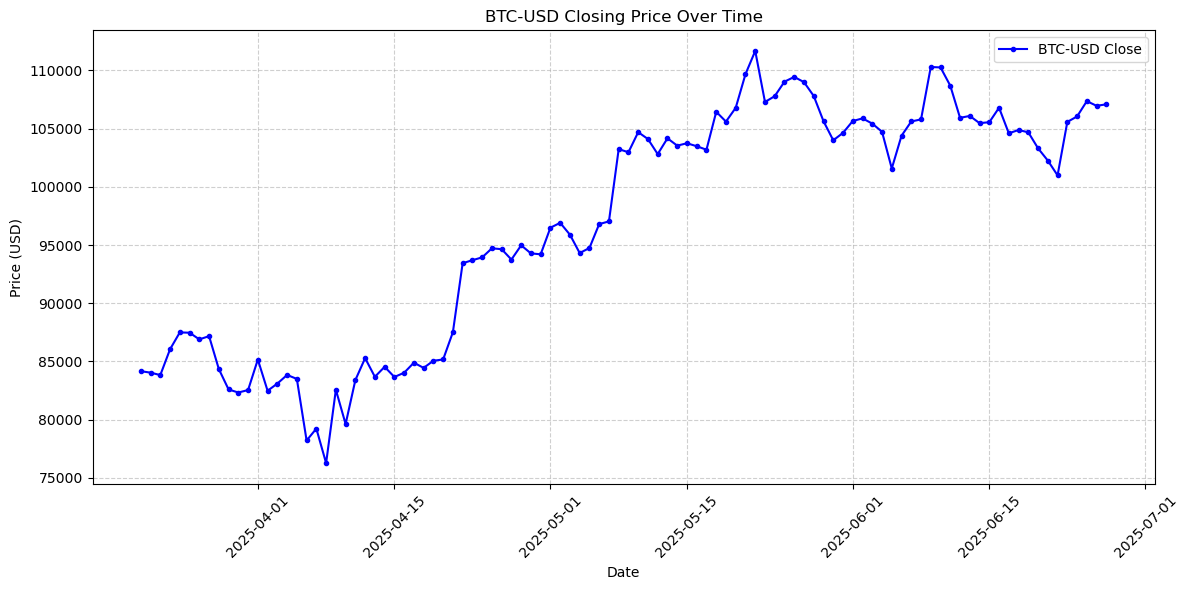

In [2]:

# --- Parameters ---
SYMBOL = 'BTC-USD'
DAYS = 100
WINDOW_SIZE = 20
PREDICT_DAYS = 10
PAST_PLOT_DAYS = 60

# --- Date range ---
end_date = date.today()
start_date = end_date - timedelta(days=DAYS)
start_str, end_str = start_date.strftime('%Y-%m-%d'), end_date.strftime('%Y-%m-%d')

# --- Download data ---
data = yf.download(SYMBOL, start=start_str, end=end_str)
data.reset_index(inplace=True)
data = data.rename(columns={
    'Date': 'date', 'Open': 'open', 'High': 'high', 'Low': 'low',
    'Close': 'close', 'Adj Close': 'adj_close', 'Volume': 'volume'
})

# --- Plot close price ---
def plot_close(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data['date'], data['close'], label=f'{SYMBOL} Close', color='blue', marker='o', markersize=3)
    plt.title(f'{SYMBOL} Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_close(data)


In [3]:
# --- Dataset generation ---
def create_dataset(series, window=WINDOW_SIZE):
    x, y = [], []
    for i in range(len(series) - window):
        x.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(x), np.array(y)

# --- Normalize and prepare data ---
scaler = MinMaxScaler()
scaled_close = scaler.fit_transform(data[['close']])
X, y = create_dataset(scaled_close)

# Reshape for LSTM: (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)

# --- Train/test split ---
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)


In [4]:

# --- Build LSTM model ---
model = Sequential([
    Input(shape=(WINDOW_SIZE, 1)),
    LSTM(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss=MeanSquaredError(), metrics=['mse'])

# --- Train model ---
history = model.fit(x_train, y_train, epochs=15, batch_size=8,
                    validation_data=(x_test, y_test), verbose=1)


Epoch 1/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 0.4565 - mse: 0.4565 - val_loss: 0.3928 - val_mse: 0.3928
Epoch 2/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.3554 - mse: 0.3554 - val_loss: 0.2772 - val_mse: 0.2772
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.2271 - mse: 0.2271 - val_loss: 0.1674 - val_mse: 0.1674
Epoch 4/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.1353 - mse: 0.1353 - val_loss: 0.0504 - val_mse: 0.0504
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0349 - val_mse: 0.0349
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0272 - mse: 0.0272 - val_loss: 0.0073 - val_mse: 0.0073
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0107 - mse: 0.0107 - val_loss: 0.0111 - val_mse: 0.0111
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0139 - mse: 0.0139 - val_loss: 0.0068 - val_mse: 0.0068
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0118 - mse: 0.0118 - 

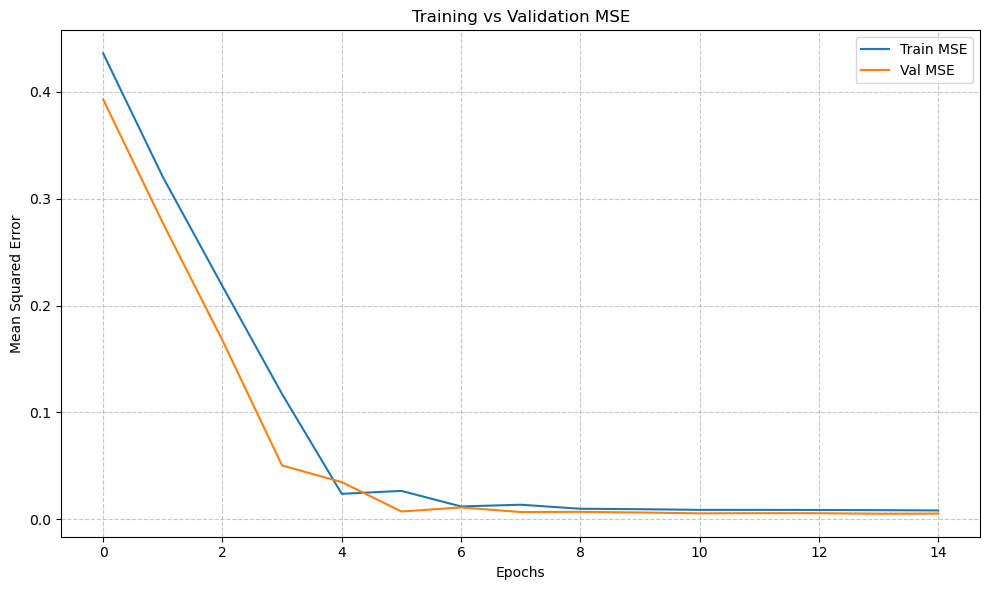

In [5]:

# --- Plot training history ---
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mse'], label='Train MSE')
    plt.plot(history.history['val_mse'], label='Val MSE')
    plt.title('Training vs Validation MSE')
    plt.xlabel('Epochs')
    plt.ylabel('Mean Squared Error')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

plot_training_history(history)

In [6]:

# --- Future prediction ---
last_sequence = scaled_close[-WINDOW_SIZE:].reshape(1, WINDOW_SIZE, 1)
predictions = []

for _ in range(PREDICT_DAYS):
    pred = model.predict(last_sequence, verbose=0)[0][0]
    predictions.append(pred)
    last_sequence = np.append(last_sequence[:, 1:, :], [[[pred]]], axis=1)

# --- Inverse scale predictions ---
predicted_prices = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))


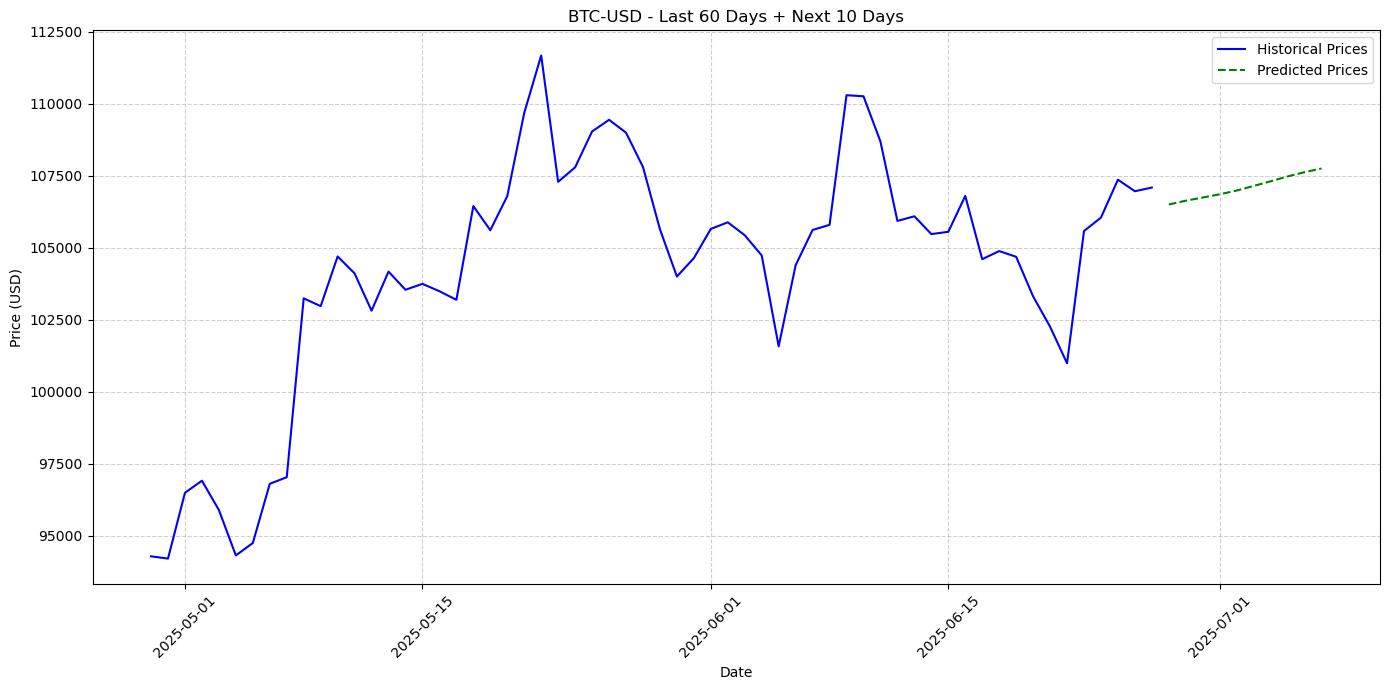

In [7]:

# --- Plot known + predicted ---
def plot_predictions(data, predicted_prices, days_back, days_forward):
    known_dates = data['date'].iloc[-days_back:]
    known_prices = data['close'].iloc[-days_back:]

    future_dates = pd.date_range(data['date'].iloc[-1] + timedelta(days=1), periods=days_forward)

    plt.figure(figsize=(14, 7))
    plt.plot(known_dates, known_prices, label='Historical Prices', color='blue')
    plt.plot(future_dates, predicted_prices, label='Predicted Prices', linestyle='--', color='green')

    plt.title(f'{SYMBOL} - Last {days_back} Days + Next {days_forward} Days')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_predictions(data, predicted_prices, PAST_PLOT_DAYS, PREDICT_DAYS)